<a href="https://colab.research.google.com/github/rajatc2/Machine-Learning/blob/main/Flower-Classification/Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Classification using Contrastive Language-Image Pretraining (CLIP)

# 0. Prepare Data

In [1]:
import json
import os
import os.path as osp
import numpy as np
from google.colab import drive
import torch
from torchvision.datasets import Flowers102
%matplotlib inline
from matplotlib import pyplot as plt

Mounted at /content/drive
1020 1020
Label: hard-leaved pocket orchid


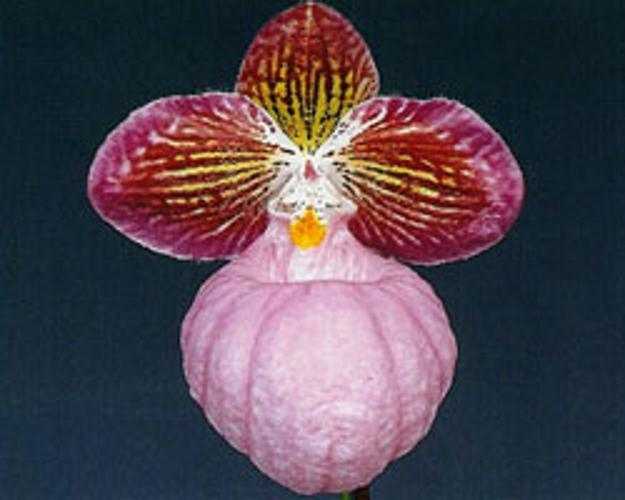

In [2]:
# Mount Drive and Load Data

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw3/"

def load_flower_data(img_transform=None):
    if os.path.isdir(datadir+ "flowers-102"):
      do_download = False
    else:
      do_download = True
    train_set = Flowers102(root=datadir, split='train', transform=img_transform, download=do_download)
    test_set = Flowers102(root=datadir, split='val', transform=img_transform, download=do_download)
    classes = json.load(open(osp.join(datadir, "flowers102_classes.json")))

    return train_set, test_set, classes

flower_train, flower_test, flower_classes = load_flower_data()
print(len(flower_train), len(flower_test))

# Display a sample in Flowers 102 dataset
sample_idx = 19 # Choose an image index that you want to display
print("Label:", flower_classes[flower_train[sample_idx][1]])
flower_train[sample_idx][0]

# 1. CLIP Prediction

In [3]:
!pip install git+https://github.com/openai/CLIP.git
import clip

# Sets device to "cuda" if a GPU is available
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)
# If this takes a really long time, stop and then restart the download
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-70fw5qin
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-70fw5qin
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=0ce35dedb94ff55c04f22fb373ac309188754521b4022f8c0f7f5a7016cb5a8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-58m8uusv/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
cuda


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 151MiB/s]


## 1a. CLIP Zero-Shot Prediction

Ground truth: giant white arum lily

Top predictions:

giant white arum lily: 62.01%
           lotus: 11.83%
      siam tulip: 6.85%
       anthurium: 4.03%
   morning glory: 1.79%


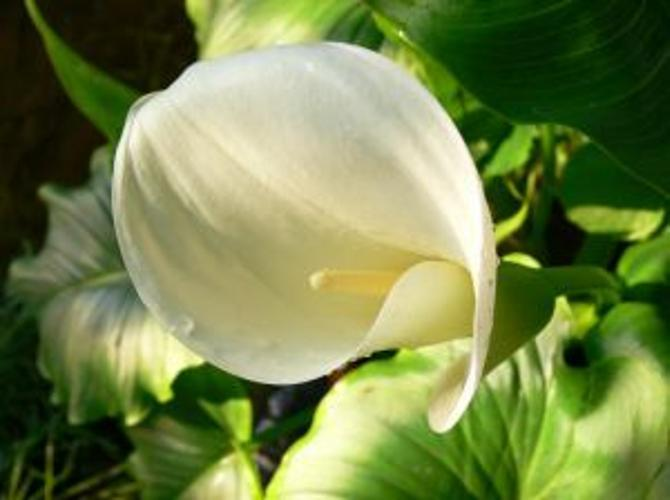

In [4]:
"""The following is an example of using CLIP pre-trained model for zero-shot prediction task"""
# Prepare the inputs
n = 200
image, class_id = flower_train[n]
image_input = clip_preprocess(image).unsqueeze(0).to(device) # extract image and put in device memory
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of flower.") for c in flower_classes]).to(device) # put text to match to image in device memory

# Calculate features
with torch.no_grad():
    image_features = clip_model.encode_image(image_input) # compute image features with CLIP model
    text_features = clip_model.encode_text(text_inputs) # compute text features with CLIP model
image_features /= image_features.norm(dim=-1, keepdim=True) # unit-normalize image features
text_features /= text_features.norm(dim=-1, keepdim=True) # unit-normalize text features

# Pick the top 5 most similar labels for the image
similarity = (100.0 * image_features @ text_features.T) # score is cosine similarity times 100
p_class_given_image= similarity.softmax(dim=-1)  # P(y|x) is score through softmax
values, indices = p_class_given_image[0].topk(5) # gets the top 5 labels

# Print the probability of the top five labels
print("Ground truth:", flower_classes[class_id])
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{flower_classes[index]:>16s}: {100 * value.item():.2f}%")
image

## 1b. CLIP zero-shot performance on Flowers 102

In [6]:
from tqdm import tqdm
from torch.utils.data import DataLoader

# Load flowers dataset again. This time, with clip_preprocess as transform
flower_train_trans, flower_test_trans, flower_classes = load_flower_data(img_transform=clip_preprocess)

In [7]:
def clip_zero_shot(data_set, classes):
    data_loader = DataLoader(data_set, batch_size=64, shuffle=False)  # dataloader lets you process in batch which is way faster
    # Needs code here
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            text_inputs = torch.cat([clip.tokenize(f"An image of {c}, a type of flower.") for c in classes]).to(device)
            image_features = clip_model.encode_image(images)
            text_features = clip_model.encode_text(text_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T)
            p_class_given_image = similarity.softmax(dim=-1)
            values, predicted = p_class_given_image.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [8]:
accuracy = clip_zero_shot(data_set=flower_test_trans, classes=flower_classes)
print(f"\nAccuracy = {100*accuracy:.3f}%")


Accuracy = 67.353%


## 1c. CLIP linear probe performance on Flowers 102

In [8]:
from sklearn.linear_model import LogisticRegression

"""
In this part, train a linear classifier on CLIP features
return: image features, labels in numpy format.
"""
def get_features(data_set):
    # Needs code here
    data_loader = DataLoader(data_set, batch_size=64, shuffle=False)

    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            image_features = clip_model.encode_image(images)
            features_list.append(image_features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            #print(type(image_features.cpu().numpy()))
            #print(type(labels.cpu().numpy()))

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    return features, labels

In [9]:
# Calculate the image features
train_features, train_labels = get_features(flower_train_trans)
test_features, test_labels = get_features(flower_test_trans)

# Perform logistic regression
# Needs code here
clf = LogisticRegression(max_iter=1000).fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
# Needs code here
accuracy = clf.score(test_features, test_labels)
print(f"\nAccuracy = {100*accuracy:.3f}%")


Accuracy = 93.627%


# 2. Nearest-Neighbor Classifier on CLIP Features

In [10]:
from scipy import stats
from sklearn.metrics import pairwise_distances

def knn(x_train, y_train, x_test, y_test, K=1):
    # Needs code here
    dist = pairwise_distances(x_test, x_train, metric='manhattan')
    kin = np.argsort(dist, axis=1)[:, :K]
    y_pred = stats.mode(y_train[kin], axis=1)[0].flatten()
    accuracy = np.mean(y_test==y_pred)

    return accuracy

In [22]:
accuracy = knn(train_features, train_labels, test_features, test_labels, K=8)
print(f"\nAccuracy = {100*accuracy:.3f}%")


Accuracy = 86.176%
